In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model
import ta
from sentiment import get_sentiment

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\caden\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [2]:
stock = yf.Ticker("BB")
df = stock.history(period='max')

In [3]:
df.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
1999-02-04 00:00:00-05:00,2.145833,2.166667,1.895833,1.924479,16788600,0.0,0.0
1999-02-05 00:00:00-05:00,1.929688,1.947917,1.822917,1.833333,3053400,0.0,0.0
1999-02-08 00:00:00-05:00,1.854167,1.927083,1.783854,1.812500,1548000,0.0,0.0
1999-02-09 00:00:00-05:00,1.822917,1.833333,1.656250,1.666667,3501600,0.0,0.0
1999-02-10 00:00:00-05:00,1.708333,1.708333,1.604167,1.677083,1597200,0.0,0.0


In [4]:
# techinical indicators for features to improve prediction

df['SMA_5'] = ta.trend.sma_indicator(df['Close'], window=5)
df['EMA_5'] = ta.trend.ema_indicator(df['Close'], window=5)
df['Stochastic_Oscillator'] = ta.momentum.StochasticOscillator(df['High'], df['Low'], df['Close'], window=5).stoch()

bollinger = ta.volatility.BollingerBands(df['Close'], window=5)
df['Bollinger_High'] = bollinger.bollinger_hband()
df['Bollinger_Low'] = bollinger.bollinger_lband()

df['Daily_Return'] = df['Close'].pct_change()
df = df.dropna()

df = df[['Close', 'Daily_Return', 'SMA_5', 'EMA_5', 'Stochastic_Oscillator', 'Bollinger_High', 'Bollinger_Low']]

In [5]:
df[['Close', 'Daily_Return', 'SMA_5', 'EMA_5', 'Stochastic_Oscillator', 'Bollinger_High', 'Bollinger_Low']].head(25)

,Close,Daily_Return,SMA_5,EMA_5,Stochastic_Oscillator,Bollinger_High,Bollinger_Low
Date,,,,,,,
1999-02-10 00:00:00-05:00,1.677083,0.006250,1.782812,1.759131,12.962850,1.979121,1.586503
1999-02-11 00:00:00-05:00,1.812500,0.080746,1.760417,1.776920,60.605968,1.905952,1.614881
1999-02-12 00:00:00-05:00,1.781250,-0.017241,1.750000,1.778364,54.838719,1.879770,1.620230
1999-02-16 00:00:00-05:00,1.708333,-0.040936,1.729167,1.755020,39.999854,1.844787,1.613546
1999-02-17 00:00:00-05:00,1.708333,0.000000,1.737500,1.739458,39.999854,1.839051,1.635949
1999-02-18 00:00:00-05:00,1.666667,-0.024390,1.735417,1.715194,17.391460,1.842135,1.628698
1999-02-19 00:00:00-05:00,1.645833,-0.012500,1.702083,1.692074,10.526138,1.794879,1.609287
1999-02-22 00:00:00-05:00,1.708333,0.037975,1.687500,1.697494,57.142764,1.740204,1.634795
1999-02-23 00:00:00-05:00,1.697917,-0.006097,1.685417,1.697635,53.846262,1.735417,1.635417


In [6]:
# adding market sentiments
market_sentiments = []
date_count = 0

# this takes a long time
for date in df.index:
    date_str = date.strftime('%Y-%m-%d')
    sentiment = get_sentiment("BB", date_str)
    market_sentiments.append(sentiment)

df['Sentiment'] = market_sentiments

In [7]:
# look into this, might cause data leakage (scaled entire train test validation set)
# min max scaler doesnt work for this (no 'limit')

scaler = StandardScaler()
scaled_stuff = scaler.fit_transform(df)
scaled_df = pd.DataFrame(scaled_stuff, index=df.index, columns=['Close', 'Daily_Return', 'SMA_5', 'EMA_5', 'Sentiment', 'Stochastic_Oscillator', 'Bollinger_High', 'Bollinger_Low'])

In [8]:
def sequence(data, window_length, forecast_horizon):
    X, y = [], []
    for i in range(len(data) - window_length - forecast_horizon + 1):
        X.append(data.iloc[i:i + window_length].values)
        y.append(data.iloc[i + window_length:i + window_length + forecast_horizon]['Close'].values)
    return np.array(X), np.array(y)

In [9]:
WINDOW_LENGTH = 20
FORECAST = 5
X, y = sequence(scaled_df, WINDOW_LENGTH, FORECAST)

print("x shape:", X.shape)
print("y shape:", y.shape)

x shape: (6394, 20, 8)
y shape: (6394, 5)


In [10]:
split_index = int(len(X) * 0.9)

X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

print("X_train:", X_train.shape)
print("y_train:", y_train.shape)
print("X_test:", X_test.shape)
print("y_test:", y_test.shape)

X_train: (5754, 20, 8)
y_train: (5754, 5)
X_test: (640, 20, 8)
y_test: (640, 5)


In [11]:
model = Sequential()
model.add(LSTM(units=100, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=25))
model.add(Dropout(0.2))
model.add(Dense(units=FORECAST))
model.summary()


c:\Users\caden\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 20, 100)        │        43,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 20, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50)             │        30,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 25)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 75,205 (293.77 KB)

 Trainable params: 75,205 (293.77 KB)

 Non-trainable params: 0 (0.00 B)

In [12]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss='mean_squared_error')
cp = ModelCheckpoint('myModel.keras', save_best_only=True)
# trains the model
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.1, callbacks=[cp])

Epoch 1/50
162/162 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - loss: 0.6496 - val_loss: 0.0161
Epoch 2/50
162/162 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.1435 - val_loss: 0.0081
Epoch 3/50
162/162 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.1085 - val_loss: 0.0054
Epoch 4/50
162/162 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.1056 - val_loss: 0.0040
Epoch 5/50
162/162 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.0855 - val_loss: 0.0046
Epoch 6/50
162/162 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 0.0916 - val_loss: 0.0058
Epoch 7/50
162/162 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 0.0875 - val_loss: 0.0036
Epoch 8/50
162/162 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 0.0702 - val_loss: 0.0029
Epoch 9/50
162/162 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.0672 - val_loss: 0.0026
Epoch 10/50
162/162 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.0679 - val_loss: 0.0019
Epoch 11/50
162/162 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.0649 - val_loss: 0.0028
Epoch 12/50
162/162 ━━━━━━━━━━━━━━━━━━━━ 

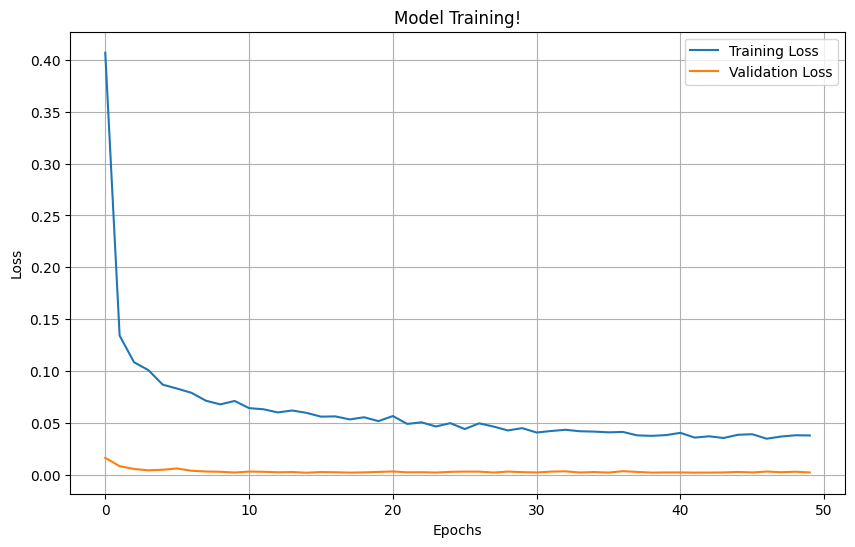

In [13]:
from plot import plot_history
plot_history(history)

In [14]:
model = load_model('myModel.keras')
predictions = model.predict(X_test)

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


In [15]:
predictions.shape

(640, 5)

In [16]:
y_pred_rescaled = np.zeros_like(predictions)

for i in range(predictions.shape[1]):
    predictions_close = predictions[:, i]
    predictions_full = np.column_stack([predictions_close] + [np.zeros_like(predictions_close)] * (df.shape[1] - 1))
    y_pred_rescaled[:, i] = scaler.inverse_transform(predictions_full)[:, 0]

y_test_rescaled = np.zeros_like(y_test)

for i in range(y_test.shape[1]):
    y_test_close = y_test[:, i]
    y_test_full = np.column_stack([y_test_close] + [np.zeros_like(y_test_close)] * (df.shape[1] - 1))
    y_test_rescaled[:, i] = scaler.inverse_transform(y_test_full)[:, 0]

In [17]:
X_test_reshaped = X_test.reshape(-1, X_test.shape[2])
X_test_rescaled_reshaped = scaler.inverse_transform(X_test_reshaped)
X_test_rescaled = X_test_rescaled_reshaped.reshape(X_test.shape)

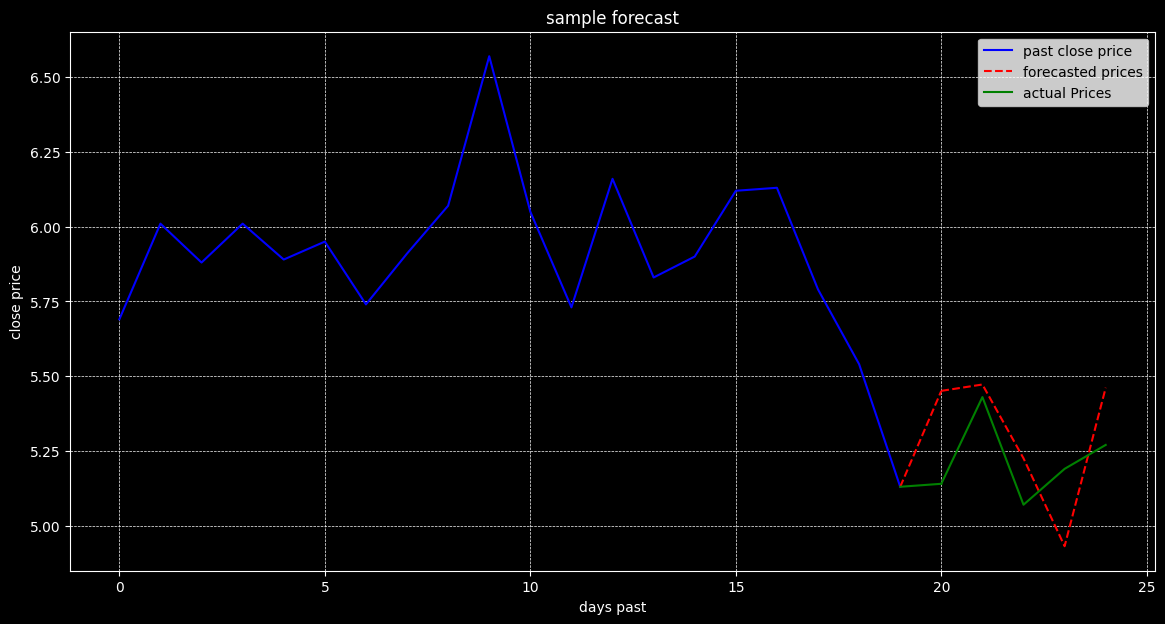

In [18]:
from plot import plot_window

window_index = 100

plot_window(X_test_rescaled, y_pred_rescaled, y_test_rescaled, window_index)

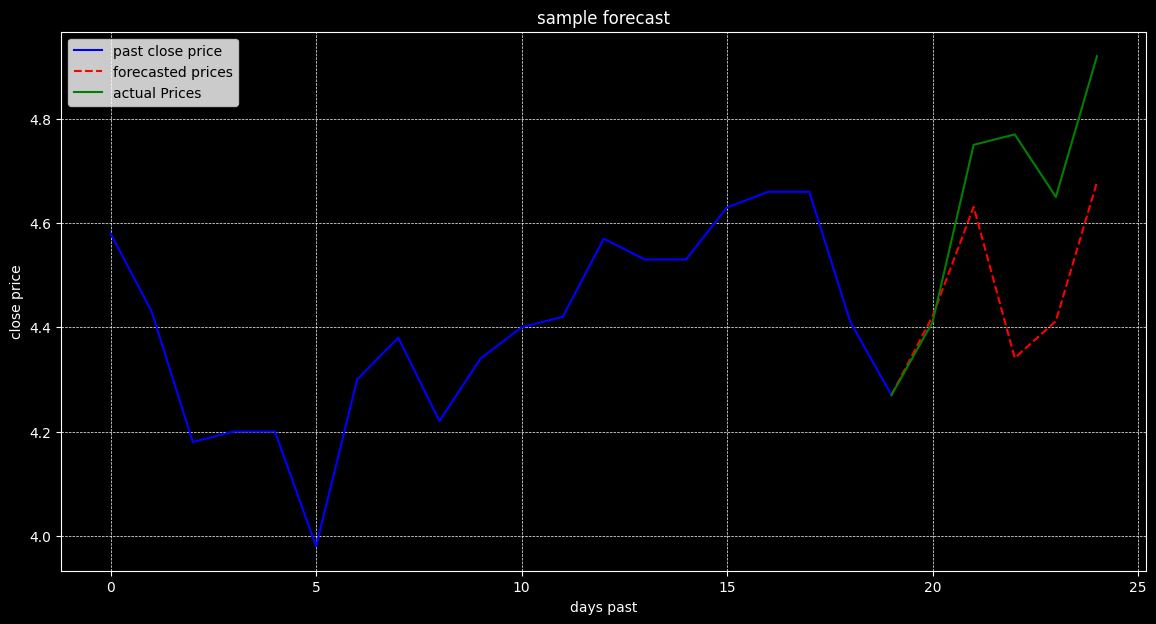

In [19]:
window_index = 200

plot_window(X_test_rescaled, y_pred_rescaled, y_test_rescaled, window_index)

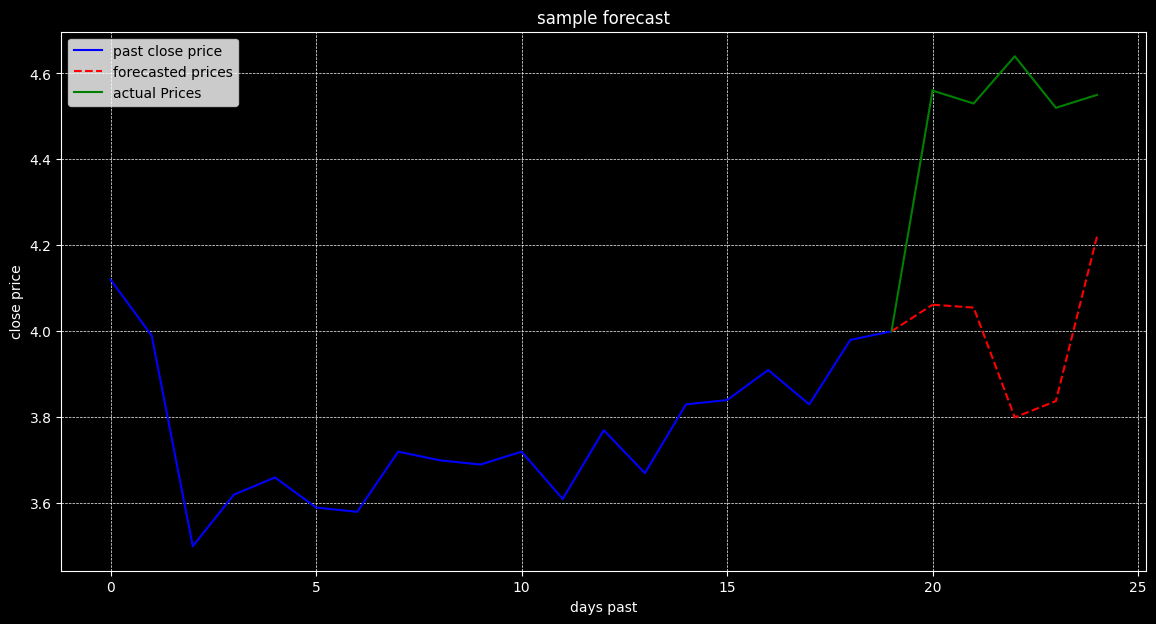

In [20]:
window_index = 300

plot_window(X_test_rescaled, y_pred_rescaled, y_test_rescaled, window_index)

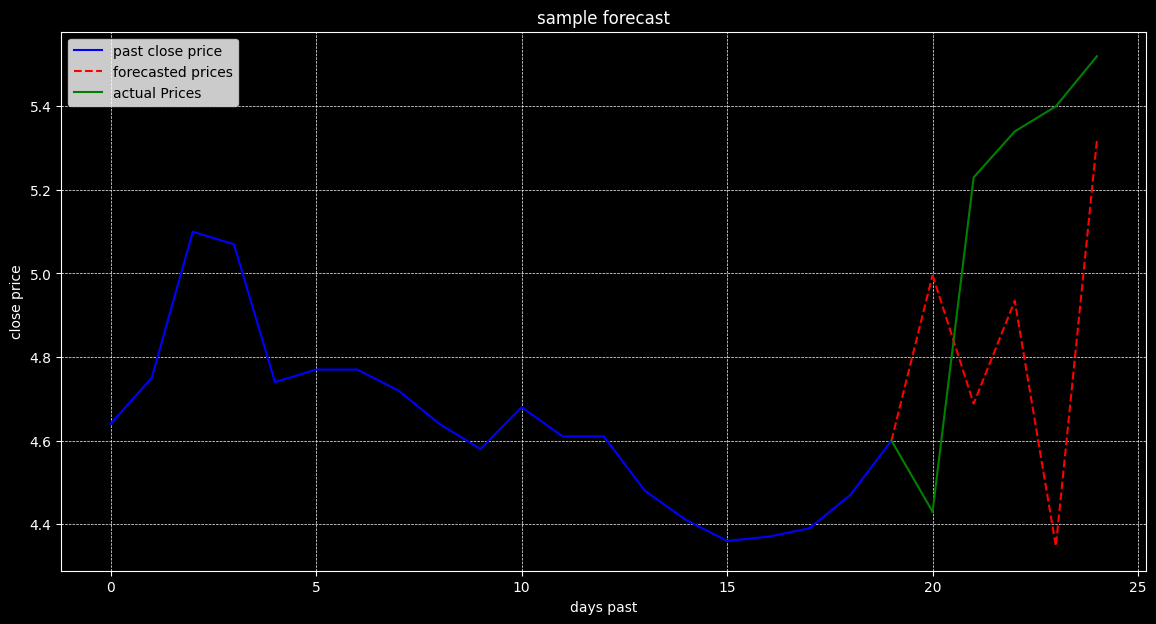

In [21]:
window_index = 400

plot_window(X_test_rescaled, y_pred_rescaled, y_test_rescaled, window_index)